In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
from scipy import integrate
import scipy as sc
from funcs import *
from scipy.integrate import odeint
import scipy.io as spio
np.set_printoptions(precision=2, suppress=True)
%matplotlib notebook
## Python 3.11.4

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["CMU"],
})

## Coupled Stuart-Landau

\begin{align}
    \dot{x}_1 &= -\omega_1 y_1 +\left(R_1^2 -(x_1^2+y_1^2)\right)x_1 +\mu(x_1 x_2 + y_1 y_2), \\
    \dot{y}_1 &= \omega_1 x_1 +\left(R_1^2 -(x_1^2+y_1^2)\right)y_1 +\mu(x_1 y_2 - y_1 x_2), \\
    \dot{x}_2 &= -\omega_2 y_2 +\left(R_2^2 -(x_2^2+y_2^2)\right)x_2, \\
    \dot{y}_2 &= \omega_2 x_2 +\left(R_2^2 -(x_2^2+y_2^2)\right)y_2,
\end{align}

R1 = 1, R2 = 0.2, ω1 = 1/π, ω2 = 1.
Bifurcation parameter $μc = \frac{|ω2 −2ω1|}{2R2} ≈ 0.91$

In [2]:
R1 = 1
R2 = 0.2
w1 = 1/np.pi
w2 = 1
u_c = np.abs(w2 - 2*w1)/(2*R2)

def SL(X, u):   
    x1, y1, x2, y2 = X
    
    dx1 = -w1*y1 + (R1**2 - (x1**2 + y1**2))*x1 + u*(x1*x2 + y1*y2)
    dy1 = w1*x1 + (R1**2 - (x1**2 + y1**2))*y1 + u*(x1*y2 - y1*x2)
    dx2 = -w2*y2 + (R2**2 - (x2**2 + y2**2))*x2
    dy2 = w2*x2 + (R2**2 - (x2**2 + y2**2))*y2
    
    return [dx1, dy1, dx2, dy2]

dt = 0.01
tf = 2000
t = np.arange(0, tf, dt)
x0 = [1e-4, 0, 1e-2, 0]
Mu = np.linspace(0, 2*u_c, 10)
n_ics = len(Mu)
new_step = int(tf/dt)

X = np.zeros((len(t), len(x0), len(Mu)))

for i in range(len(Mu)):
    mu = Mu[i]
    sol = odeint(lambda x, t: SL(x, mu), x0, t, rtol=1e-10)
    X[:, :, i] = sol

<IPython.core.display.Javascript object>


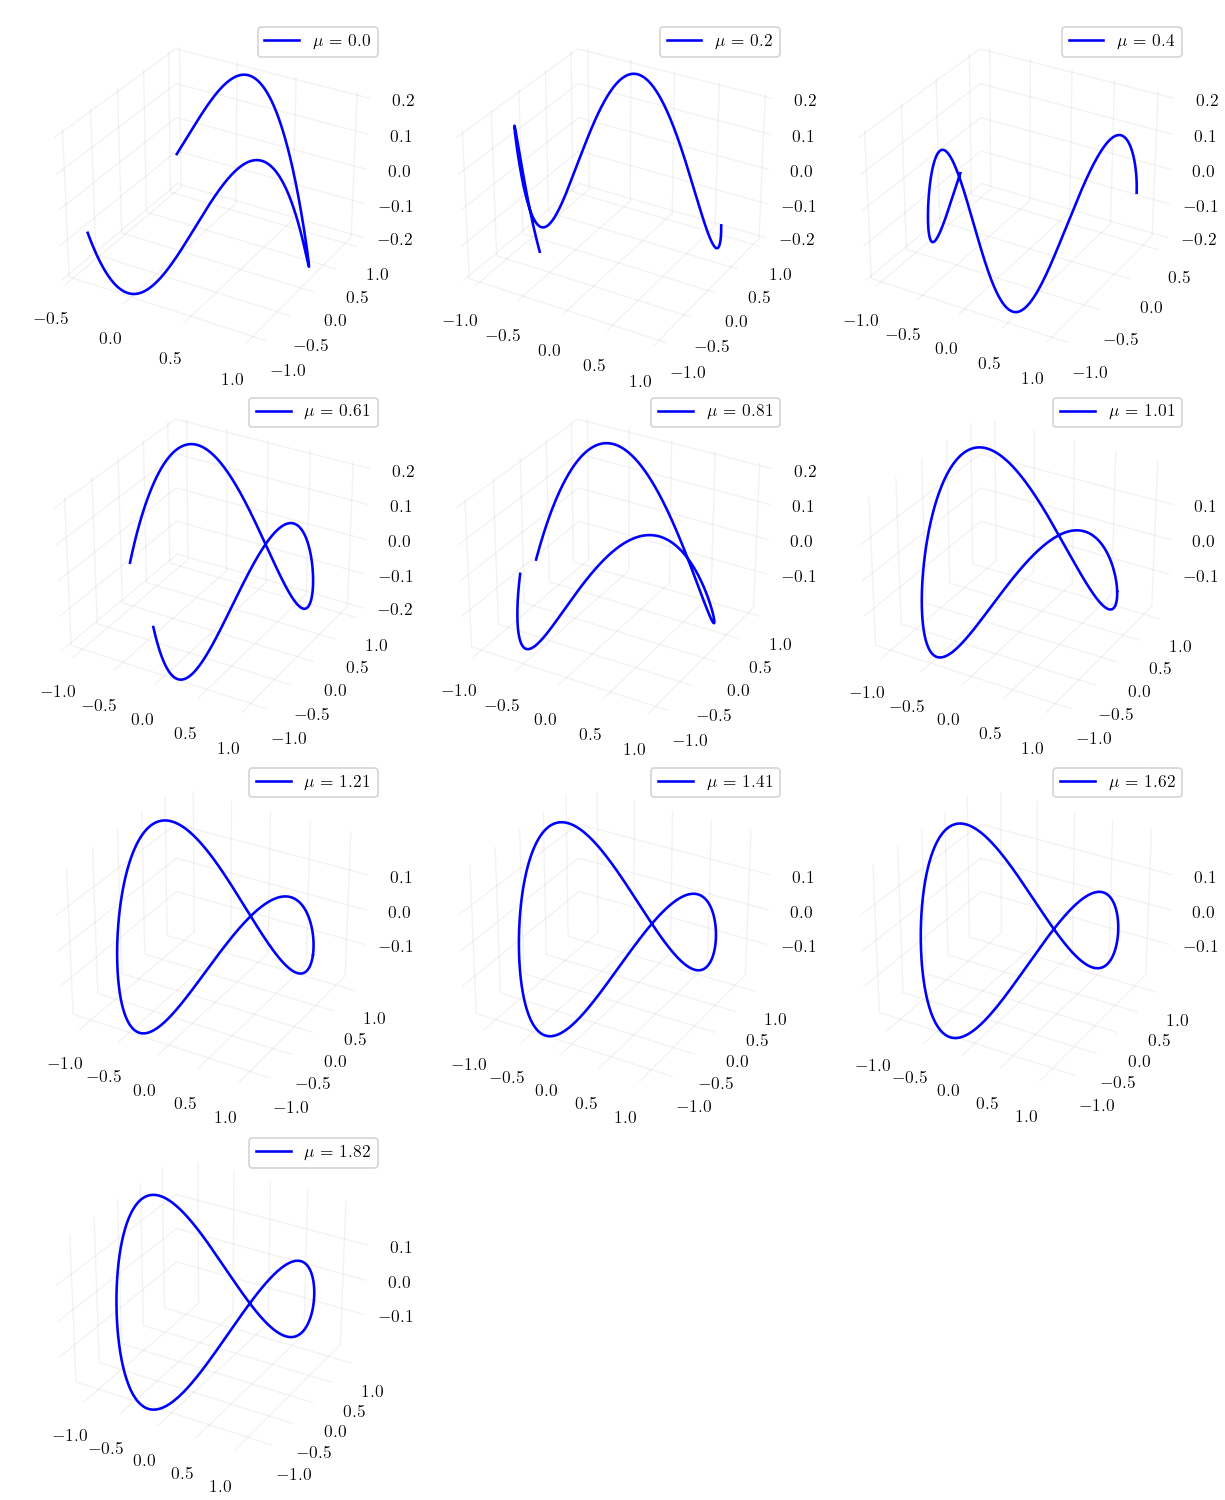

In [3]:
'''
3D PLOT
'''

m1 = 198745
m2 = 200000

num_plots = len(Mu)
rows = 4  # Define the number of rows in the subplot grid
cols = (num_plots + rows - 1) // rows  # Calculate the number of columns needed

plt.rcParams['grid.color'] = (0.05, 0.05, 0.05, 0.05)
fig = plt.figure(figsize=(9.8, 12))  # Set the overall figure size

for k in range(num_plots):

    # Create a new subplot for each iteration
    ax = fig.add_subplot(rows, cols, k + 1, projection='3d')

    tuples = (0., 0., 0., 0.)
    ax.xaxis.line.set_color(tuples)
    ax.yaxis.line.set_color(tuples)
    ax.zaxis.line.set_color(tuples)
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = (0, 0, 0)
        axis._axinfo['tick']['inward_factor'] = 0.0
        axis._axinfo['tick']['outward_factor'] = 0.0
        axis.set_pane_color((1, 1, 1))

    ax.tick_params(axis='x', size=30)
    ax.tick_params(axis='y', size=30)
    ax.tick_params(axis='z', size=30)

    x_plot, y_plot, z_plot = (X[m1:m2, 0, k], X[m1:m2, 1, k], X[m1:m2, 2, k])
    ax.plot(x_plot, y_plot, z_plot, "b", label=f'$\mu$ = {np.round(Mu[k], 2)}')
    plt.legend()

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()

In [4]:
'''
CONCATENATE DATA
'''

x_real = np.zeros((len(Mu)*t.size, 5))

for i in range(len(Mu)):
    x_real[i*new_step:(i+1)*new_step, :4] = X[:, :, i]
    x_real[i*new_step:(i+1)*new_step, 4] = Mu[i]
t_real = np.array(list(t)*len(Mu)).reshape(-1,1)

x_real.shape, t_real.shape, new_step

((2000000, 5), (2000000, 1), 200000)

In [5]:
'''
CREATE STATIONARY DATA ARRAYS
'''
n_est = new_step - (m2-m1)

x_est = est(x_real, n_est, new_step, len(Mu))
t_est = np.array(list(t_real[n_est:new_step])*len(Mu))

In [6]:
'''
CREATE TRANSIENT DATA ARRAYS
'''
n_trans = 4*(m2-m1)

x_trans = trans(x_real, n_trans, new_step, len(Mu))
t_trans = np.array(list(t_real[:n_trans])*len(Mu))


'''
SINGLE TRANSIENT
'''
T = 9
few_X = x_trans[T*n_trans:(T+1)*n_trans, :]
few_t = t_trans[T*n_trans:(T+1)*n_trans, :]

For the single transient trajectory, pick the one that is closest to the bifurcation.
Dataset details: initial condition, parameter values, simulation time, sampling time and number of samples, points
retained for transients, points retained on the attractor, parameter for flagged single transient.

In [7]:
# true_dynamics_3 = mysindy2(x_real, t_real, 0.005, 3, normalize=True)[0]

# Save the array to a file
# np.save('true_dynamics_3.npy', true_dynamics_3)

# Load the array from the file
true_dynamics_3 = np.load('true_dynamics_3.npy')

In [8]:
def musindy(X, t, polyorder, lamb, alpha, dX):
    '''
    Returns a sequential threshholded sparse regression by applying constrained-least-squares regression recursively
    to a pre-normalized candidate library matrix by its maximum value.

    polyorder: Polynomial Order

    '''
    vals, dims = X.shape  # dims --> number of columns

#     dX = deriv4_time(X, t)

    library = PolynomialFeatures(polyorder)
    THETA = library.fit_transform(X)
    variable_names = library.fit(X[:dims, :]).get_feature_names_out(['x1', 'y1', 'x2', 'y2', 'u'][0:dims])

    l = THETA.shape[1]

    # Initialize constraints -------------------------------------------------------------------------
    n_constraints = ptss.shape[0] # + pts_eq.shape[0] 

    C = np.zeros((n_constraints, l))
    d = np.zeros((n_constraints, dims))

    idx = 0  # Index for row of C and element of vector d

    for p in ptss:         
        arr = library.fit_transform(np.array([p])).flatten()
        C[idx, :] = arr
        d[idx] = ptss_dx[idx, :]
        idx += 1

#     for p in pts_eq:         
#         arr = library.fit_transform(np.array([p])).flatten()
#         C[idx, :] = arr
#         idx += 1

    # -------------------------------------------------------------------------------------------------
    THETA_C = np.r_[THETA, np.sqrt(alpha)*C]
    dX = np.r_[dX, np.sqrt(alpha)*d]

    # -------------------------------------------------------------------------------------------------
    #NORMALIZE COLUMNS
    THETAp = np.zeros_like(THETA_C)
    norms = np.zeros(THETA_C.shape[1])
    for i in range(THETA_C.shape[1]):
        
        norms[i] = np.max(np.abs(THETA_C[:, i]))
        THETAp[:, i] = THETA_C[:, i]/np.max(np.abs(THETA_C[:, i]))
        
    THETA = THETAp
    # -------------------------------------------------------------------------------------------------

    # Initial guess
    CHI = np.linalg.pinv(THETA)@dX

    # Seq. Threshholding
    for k in range(5):
        for i in range(dims):
            lamb2 = np.max(np.abs(CHI[:, i]))*lamb
            smallinds = np.abs(CHI[:, i]) < lamb2
            CHI[smallinds, i] = 0  # Mask
            biginds = smallinds == 0
            CHI[biginds, i] = np.linalg.pinv(THETA[:, biginds])@dX[:, i]

    for i in range(dims):
        CHI[:, i] = CHI[:, i]/norms

    return CHI, variable_names, polyorder

In [9]:
'''
OBTAIN [HIGH FIDELITY] POINTS FOR CONSTRAINTS                                           ADD NOISE TO THE EQUILIBRIA HERE
'''
space = 100

sampling = BurstSampling(x_est, t_est, 5, space)
ptss_dx = sampling[0]
ptss = sampling[1]
t_pts = sampling[2]
ptss_total = sampling[3]
t_total = sampling[4]

n_ptss = int(ptss.shape[0]/10)

<IPython.core.display.Javascript object>


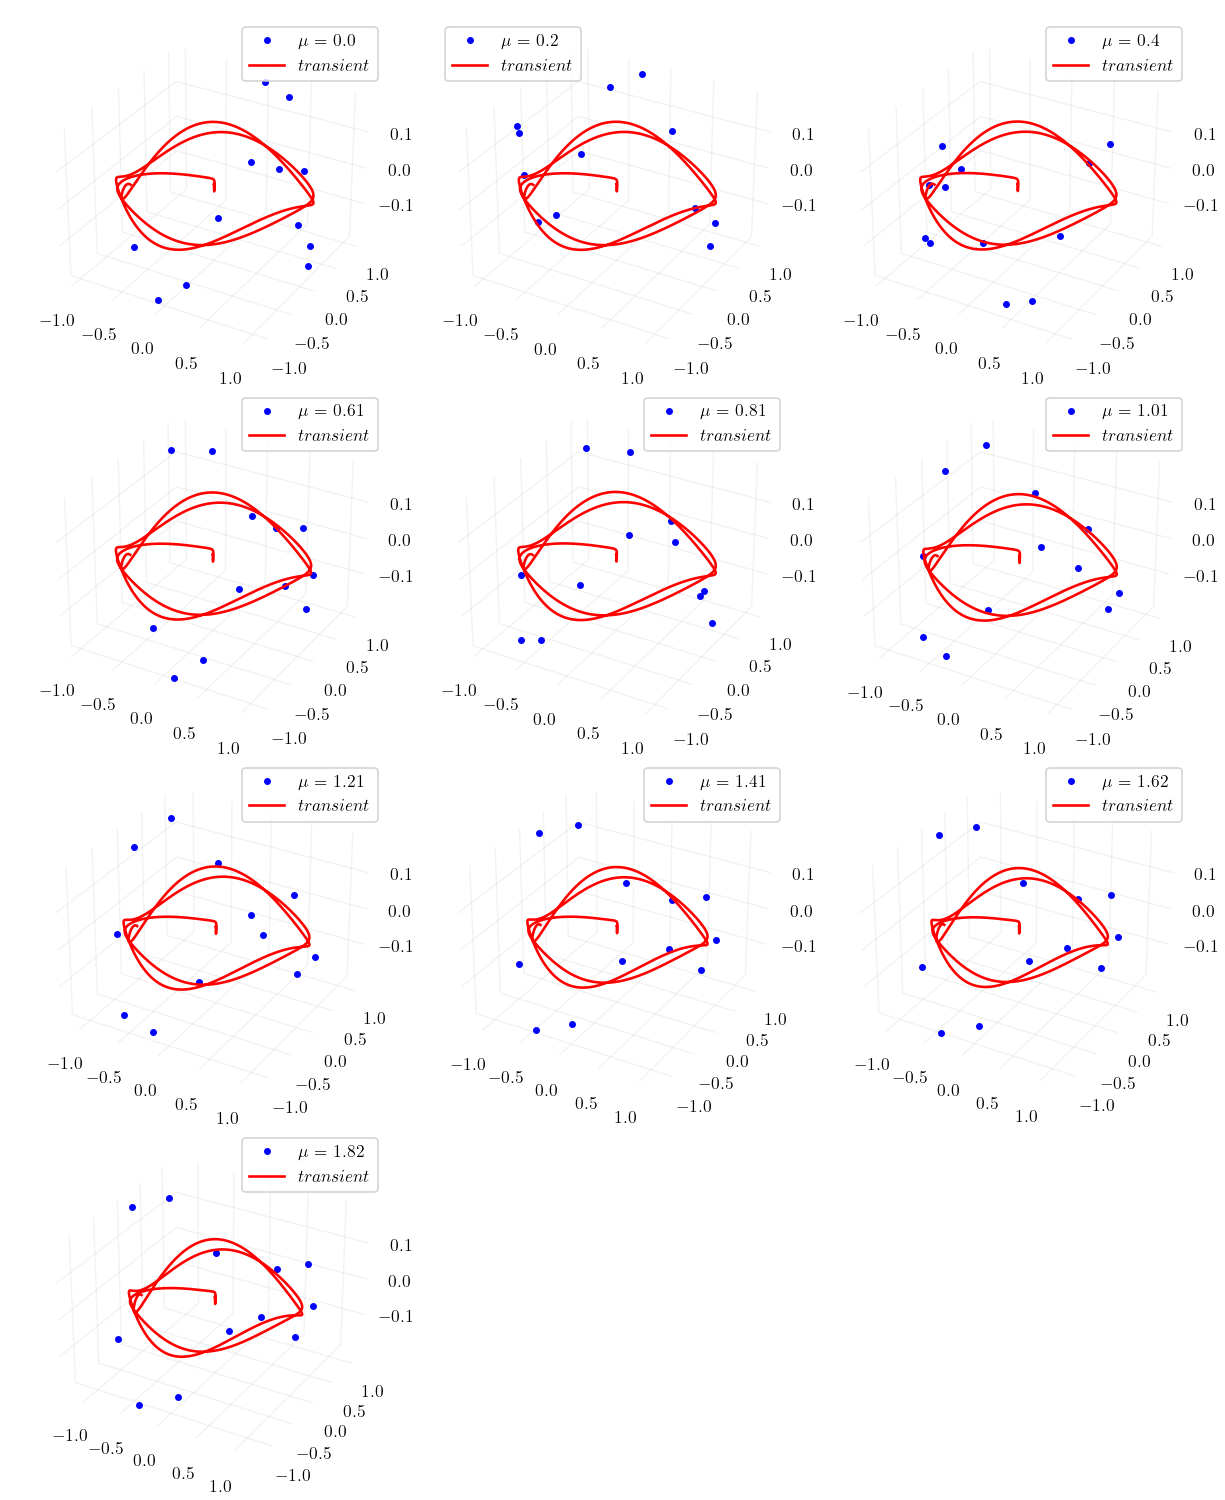

In [10]:
num_plots = len(Mu)
rows = 4  # Define the number of rows in the subplot grid
cols = (num_plots + rows - 1) // rows  # Calculate the number of columns needed

fig = plt.figure(figsize=(9.8, 12))  # Set the overall figure size

idx = 0
for k in range(num_plots):
    plt.rcParams['grid.color'] = (0.05, 0.05, 0.05, 0.05)

    # Create a new subplot for each iteration
    ax = fig.add_subplot(rows, cols, k + 1, projection='3d')

    tuples = (0., 0., 0., 0.)
    ax.xaxis.line.set_color(tuples)
    ax.yaxis.line.set_color(tuples)
    ax.zaxis.line.set_color(tuples)
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = (0, 0, 0)
        axis._axinfo['tick']['inward_factor'] = 0.0
        axis._axinfo['tick']['outward_factor'] = 0.0
        axis.set_pane_color((1, 1, 1))

    ax.tick_params(axis='x', size=30)
    ax.tick_params(axis='y', size=30)
    ax.tick_params(axis='z', size=30)
    
    ax.plot(ptss[idx*n_ptss:(idx+1)*n_ptss, 0], ptss[idx*n_ptss:(idx+1)*n_ptss, 1], ptss[idx*n_ptss:(idx+1)*n_ptss, 2], ".b", label=f'$\mu$ = {np.round(Mu[k], 2)}')
    ax.plot(few_X[:, 0], few_X[:, 1], few_X[:, 2], "r", label=f'$transient$')
    idx += 1
    plt.legend()

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()

In [11]:
LAMBDA = 0.0087
ALPHA = 1e10

In [12]:
coeffsw = musindy(few_X, few_t, 3, LAMBDA, ALPHA, deriv4_time(few_X, few_t))  # 1e14
coeffsw[0][:25]

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  0.32,  0.  ,  0.  , -0.  ],
       [-0.32,  1.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  0.  ,  0.04,  1.  ,  0.  ],
       [ 0.  ,  0.  , -1.  ,  0.04,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [-1.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -1.  ,  0.  ,  0.

In [13]:
coeffs = musindy(few_X, few_t, 3, LAMBDA, 1, deriv4_time(few_X, few_t))
coeffs[0]

array([[ 0.  ,  0.  , -0.01,  0.  , -0.  ],
       [ 1.  ,  0.32,  0.  ,  0.  ,  0.  ],
       [-0.32,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.04,  1.  ,  0.  ],
       [ 0.  ,  0.  , -1.  ,  0.04,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.13,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.13,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [-1.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -1.  ,  0.  ,  0.

In [14]:
from numpy.linalg import norm
from numpy.random import normal, permutation, seed

grid_length = 11
seeds = np.arange(0, (grid_length**2)*1000+1, 1)*10

Ec_14_final = []
Ec_1_final = []

Em_14_final = []
Em_1_final = []

rango_ruido = np.linspace(0, 0.005, grid_length)
rango_l = np.linspace(n_trans, n_trans*0.5, grid_length, dtype=int)

seed_idx = 0
for noise in rango_ruido:
    Ec_14_inicial = []
    Ec_1_inicial = []
    
    Em_14_inicial = []
    Em_1_inicial = []
    for largo in rango_l:
        for i in range(500):   # ITERATIONS HERE
            seed(seeds[seed_idx])

            '''
            CHOOSE 1 TRANSIENT FOR THE REGRESSION                                   ADD NOISE TO THE TRANSIENT HERE
            '''
            eps = noise
            signal_power = np.sqrt(np.mean(few_X**2))
            sigma = eps*signal_power

            x_Trans2 = few_X + np.c_[sigma * normal(size=(n_trans, 4)), np.zeros(n_trans)]
            x_Trans_prior = x_Trans2
            t_Trans_prior = t
            dX_prior = deriv4_time(x_Trans_prior, t_Trans_prior)

            '''
            apply algorithm to decimated arrays
            '''
            data_length = largo
            mask = np.sort(permutation(np.arange(x_Trans_prior.shape[0]))[:data_length])

            x_Trans = x_Trans_prior[mask]
            t_Trans = t_Trans_prior[mask]
            dX = dX_prior[mask]

            coeffsw = musindy(x_Trans, t_Trans, 3, LAMBDA, ALPHA, dX)
            coeffs_OG = musindy(x_Trans, t_Trans, 3, LAMBDA, 1, dX)
            # ------------------------------------------------- MODEL ERROR --------------------------------

            Ec_14_inicial.append(norm(coeffsw[0]-true_dynamics_3, ord='fro')/norm(true_dynamics_3, ord='fro'))
            Ec_1_inicial.append(norm(coeffs_OG[0]-true_dynamics_3, ord='fro')/norm(true_dynamics_3, ord='fro'))

            # --------------------------------------------------- SUCCESS RATE ---------------------------------
            sparsity_true = (abs(true_dynamics_3) > 0.001)*1
            sparsity_w = (abs(coeffsw[0]) > 0.001)*1
            sparsity_OG = (abs(coeffs_OG[0]) > 0.001)*1
    
            if norm(sparsity_true - sparsity_w) < 1e-3:
                Em_14_inicial.append(1)
            else:
                Em_14_inicial.append(0)

            if norm(sparsity_true - sparsity_OG) < 1e-3:
                Em_1_inicial.append(1)
            else:
                Em_1_inicial.append(0)

            seed_idx += 1

        Em_14_final.append(np.mean(Em_14_inicial))
        Em_1_final.append(np.mean(Em_1_inicial))
        
        Ec_14_final.append(np.mean(Ec_14_inicial))
        Ec_1_final.append(np.mean(Ec_1_inicial))

In [15]:
EC_MUSINDY = np.zeros((len(rango_ruido), len(rango_l)))
EC_OG = np.zeros_like(EC_MUSINDY)

EM_MUSINDY = np.zeros_like(EC_MUSINDY)
EM_OG = np.zeros_like(EC_MUSINDY)


iii = 0
for i in range(len(rango_ruido)): #noise
    for j in range(len(rango_l)): #largo
        EC_MUSINDY[(len(rango_l)-1)-j, i] = Ec_14_final[iii]
        EC_OG[(len(rango_l)-1)-j, i] = Ec_1_final[iii]
        EM_MUSINDY[(len(rango_l)-1)-j, i] = Em_14_final[iii]
        EM_OG[(len(rango_l)-1)-j, i] = Em_1_final[iii]
        iii += 1

In [16]:
# from scipy.io import savemat, loadmat

# dicc = {'EC_OG': EC_OG,
#         'EC_MUSINDY': EC_MUSINDY,
#         'EM_OG': EM_OG,
#         'EM_MUSINDY': EM_MUSINDY    
#        }

# savemat('heat_data_SL3.mat', dicc)

In [23]:
from scipy.io import loadmat

DF = loadmat('heat_data_SL3.mat')
EC_OG = DF['EC_OG']
EC_MUSINDY = DF['EC_MUSINDY']
EM_OG = DF['EM_OG']
EM_MUSINDY = DF['EM_MUSINDY']

<IPython.core.display.Javascript object>


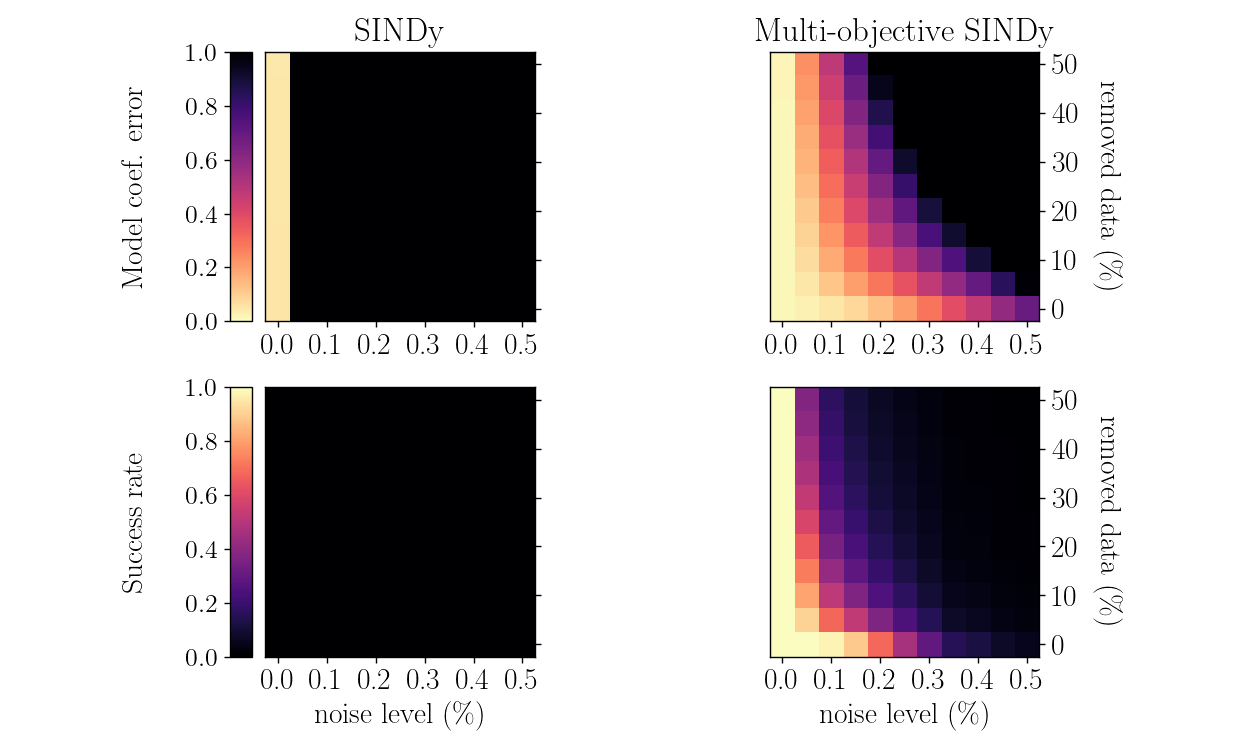

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Crear la figura y las subtramas
fig, axs = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [1, 1]})

vmin = 0
vmax = 1

xticks = np.linspace(rango_ruido[0], rango_ruido[-1], 6, endpoint=True) * 100
yticks = np.linspace((1-rango_l[-1]/rango_l[0])*100, 0, 6, endpoint=True, dtype=int)

FTSIZE = 17

# Gráfico 1
im1 = axs[0, 0].imshow(EC_OG, cmap='magma_r', vmin=vmin, vmax=vmax)
axs[0, 0].set_title('SINDy', fontsize=FTSIZE+2)
axs[0, 0].set_xticks(range(0, len(rango_ruido) + 1, 2))
axs[0, 0].set_xticklabels(xticks, fontsize=FTSIZE)  # Set x-axis tick labels as integers 
axs[0, 0].set_yticks(range(0, len(rango_ruido) + 1, 2))
axs[0, 0].set_yticklabels(yticks, fontsize=FTSIZE)
axs[0, 0].tick_params(axis='y', right=True, left=False, labelright=False, labelleft=False)
axs[0, 0].set_ylabel('Success rate', fontsize=FTSIZE, labelpad=20)

# Remove y-label of the leftmost plot
axs[0, 0].set_ylabel('')

axs[0, 1].tick_params(axis='y', right=True, left=False, labelright=True, labelleft=False)

# Gráfico 2
im2 = axs[0, 1].imshow(EC_MUSINDY, cmap='magma_r', vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Multi-objective SINDy', fontsize=FTSIZE+2)
axs[0, 1].set_xticks(range(0, len(rango_ruido) + 1, 2))
axs[0, 1].set_xticklabels(xticks, fontsize=FTSIZE)  # Set x-axis tick labels as integers
axs[0, 1].set_yticks(range(0, len(rango_ruido) + 1, 2))
axs[0, 1].set_yticklabels(yticks, fontsize=FTSIZE)
axs[0, 1].set_ylabel('removed data (\%)', fontsize=FTSIZE, rotation=270, labelpad=25)

# -----------------------------------------------------------------------------------------------------------------------

vmin2 = 0
vmax2 = 1

# Gráfico 4
im4 = axs[1, 0].imshow(EM_OG, cmap='magma', vmin=vmin2, vmax=vmax2)
axs[1, 0].set_xticks(range(0, len(rango_ruido) + 1, 2))
axs[1, 0].set_xticklabels(xticks, fontsize=FTSIZE)  # Set x-axis tick labels as integers
axs[1, 0].set_yticks(range(0, len(rango_ruido) + 1, 2))
axs[1, 0].set_yticklabels(yticks, fontsize=FTSIZE)
axs[1, 0].tick_params(axis='y', right=True, left=False, labelright=False, labelleft=False)

# Gráfico 5
im5 = axs[1, 1].imshow(EM_MUSINDY, cmap='magma', vmin=vmin2, vmax=vmax2)
axs[1, 1].set_xticks(range(0, len(rango_ruido) + 1, 2))
axs[1, 1].set_xticklabels(xticks, fontsize=FTSIZE)  # Set x-axis tick labels as integers
axs[1, 1].set_yticks(range(0, len(rango_ruido) + 1, 2))
axs[1, 1].set_yticklabels(yticks, fontsize=FTSIZE)
axs[1, 1].tick_params(axis='y', right=True, left=False, labelright=True, labelleft=False)

axs[1, 1].set_ylabel('removed data (\%)', fontsize=FTSIZE, rotation=270, labelpad=25)

# -----------------------------------------------------------------------------------------------------------------------

# Add x-axis labels to the bottom subplots
axs[1, 0].set_xlabel('noise level (\%)', fontsize=FTSIZE)
axs[1, 1].set_xlabel('noise level (\%)', fontsize=FTSIZE)

# Move y-axis labels to the right of the rightmost plot
axs[0, 1].yaxis.set_label_position("right")
axs[1, 1].yaxis.set_label_position("right")

# Add colorbars to the left of every row
divider1 = make_axes_locatable(axs[0, 0])
cax1 = divider1.append_axes("left", size="8%", pad='5%')
cax1.tick_params(labelsize=15)
cbar1 = plt.colorbar(im2, cax=cax1)
cbar1.set_label('Model coef. error', fontsize=17, labelpad=-75, rotation=90)
cbar1.ax.yaxis.set_ticks_position("left")

divider2 = make_axes_locatable(axs[1, 0])
cax2 = divider2.append_axes("left", size="8%", pad='5%')
cax2.tick_params(labelsize=15)
cbar2 = plt.colorbar(im4, cax=cax2)
cbar2.set_label('Success rate', fontsize=17, labelpad=-75, rotation=90)
cbar2.ax.yaxis.set_ticks_position("left")

# Ajustar el espaciado entre subtramas
plt.tight_layout()

# Mostrar el gráfico
plt.show()
plt.savefig('StuartLandau_heatmap_3rd.pdf')

In [19]:
library_test = PolynomialFeatures(3)
theta_tr = library_test.fit_transform(x_trans)
theta_att = library_test.fit_transform(ptss)
theta_tr.shape, theta_att.shape

((50200, 56), (120, 56))

In [20]:
import scipy.io

data_SL = {
             'x0': x0,
             'Mu': Mu,
             'mu_tr': few_X[0, -1],
             'dt': dt,
             'r': [12]*10,
             'm': [n_trans]*10,
             'X_tr': x_trans,
             'X_att': ptss, # x_est
             't_att': t_pts,
             'X_dot_tr': deriv4_time(x_trans, t_trans),
             'X_dot_att': ptss_dx,
             'Theta_tr': theta_tr,
             'Theta_att': theta_att,
             'theta': coeffsw[1],
             'lambda': [LAMBDA],
             'alpha_exp': str(ALPHA)
            }

scipy.io.savemat('data_SL.mat', data_SL)

## Condition Number

In [21]:
cond_c = []
cond_c_c = []
cond_THETA = []
cond_trans = []
rango_alpha = np.logspace(-50, 40, num=50)

X = few_X
vals, dims = X.shape  # dims --> number of columns
    
# --> Initialize the return array.
library = PolynomialFeatures(coeffsw[-1])
THETA = library.fit_transform(X)
variable_names = library.fit(X[:2]).get_feature_names_out(['x1', 'y1', 'x2', 'y2', 'u'][0:dims])
l = len(variable_names)

# Initialize constraints -------------------------------------------------------------------------
n_constraints = ptss.shape[0] 
C = np.zeros((n_constraints, l))

for alpha in rango_alpha:
    idx = 0  # Index for row of C and element of vector d
    for p in ptss:         
        arr = list(library.fit_transform(np.array([p])).flatten())
        C[idx, :] = np.array(arr)
        idx += 1

#     for p in pts_eq:         
#         arr = list(library.fit_transform(np.array([p])).flatten())
#         C[idx, :] = np.array(arr)
#         idx += 1
        
    THETA_C = np.r_[THETA, np.sqrt(alpha)*C]

    cond_c.append(np.linalg.cond((C)))                   # PUNTOS RESTRICCION            np.sqrt(alpha)*
    cond_c_c.append(np.linalg.cond(THETA_C))             # TRANSIENTE + PUNTOS RESTRICCION
    cond_THETA.append(np.linalg.cond(THETA))             # SOLO TRANSIENTE
    cond_trans.append(np.linalg.cond(library.fit_transform(x_trans)))  # VARIOS TRANSIENTES

<IPython.core.display.Javascript object>


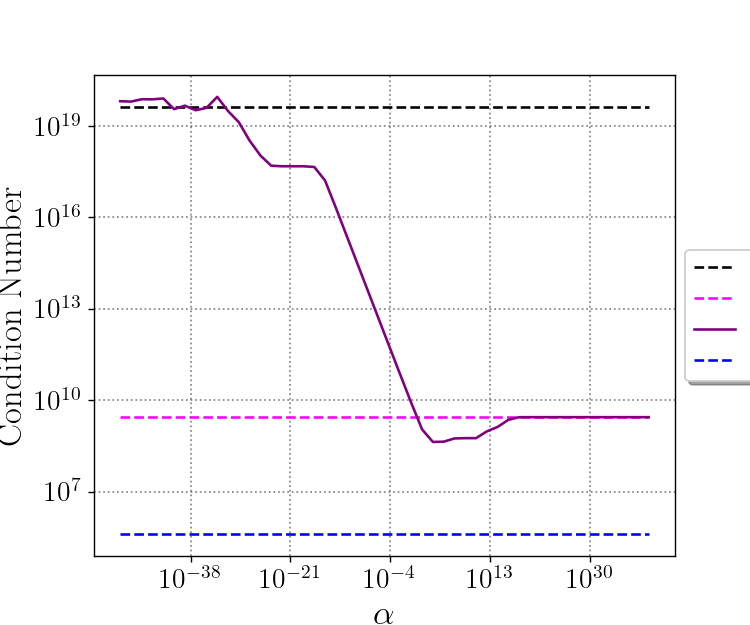

In [22]:
plt.figure(figsize=(6, 5))
plt.loglog(rango_alpha, cond_THETA, '--k', label=r'$\Theta(X)$: Single transient')
plt.loglog(rango_alpha, cond_c, 'magenta', linestyle='--', label=r'$\Theta(\sqrt{\alpha} C)$: Data in the attractor')
plt.loglog(rango_alpha, cond_c_c, 'purple', label=r'$\Theta(X) + \sqrt{\alpha}C$: Single transient + data in the attractor')
plt.loglog(rango_alpha, cond_trans, '--b', label='$\Theta(X_{total})$: '+str(len(Mu))+' transients')
plt.xlabel('$\\alpha$', fontsize=20)
plt.ylabel('Condition Number', fontsize=20)

plt.grid(True)  # Add major grid
plt.minorticks_on()  # Enable minor ticks
plt.grid(True, which='both', linestyle=':', linewidth=1, alpha=0.5)  # Add minor grid
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True, fontsize=12)

# Enlarge ticks
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=14)

plt.show()